# Prysm RLNC Block Arrivals Analysis

This notebook analyzes the impact of Random Linear Network Coding (RLNC) implementation by Prysm on beacon block propagation times. We compare block arrival times and block sizes between networks that have and have not implemented RLNC.

In [1]:
# Import necessary packages
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta

# Add scripts directory to path
sys.path.append('./scripts')

# Import custom modules
from bootstrap import load_env, create_db_url, add_branding, process_config
from clickhouse import ClickhouseClient
from transforms import process_block_data, process_block_size_data, calculate_arrival_metrics, compare_networks

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/Users/samcm/.pyenv/versions/anaconda3-2022.05/envs/ldm/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Configuration
config = {
    "before": {
        "network": "nft-devnet-6",
        "start_at_slot": 300,
        "finish_at_slot": 600
    },
    "after": {
        "network": "nft-devnet-5",
        "start_at_slot": 300,
        "finish_at_slot": 600
    }
}

# Validate and process the config
config = process_config(config)

# Load environment variables
credentials = load_env()
db_url = create_db_url(credentials)

# Initialize Clickhouse client
clickhouse = ClickhouseClient(db_url)

## Data Collection

Let's collect block arrival data from both networks.

In [3]:
# Fetch data for the "before" network (NFT-Devnet-2)
print(f"Fetching data for {config['before']['network']} (before RLNC)...")

before_block_data = clickhouse.fetch_block_arrival_times(
    config['before']['network'], 
    config['before']['start_at_slot'], 
    config['before']['finish_at_slot']
)

before_block_size_data = clickhouse.fetch_block_size_data(
    config['before']['network'], 
    config['before']['start_at_slot'], 
    config['before']['finish_at_slot']
)

# Fetch data for the "after" network (NFT-Devnet-3)
print(f"Fetching data for {config['after']['network']} (after RLNC)...")

after_block_data = clickhouse.fetch_block_arrival_times(
    config['after']['network'], 
    config['after']['start_at_slot'], 
    config['after']['finish_at_slot']
)

after_block_size_data = clickhouse.fetch_block_size_data(
    config['after']['network'], 
    config['after']['start_at_slot'], 
    config['after']['finish_at_slot']
)

Fetching data for nft-devnet-6 (before RLNC)...
Fetching data for nft-devnet-5 (after RLNC)...


## Data Processing

Now let's process the data to calculate metrics for both networks.

In [4]:
# Process data for before network
before_combined = process_block_data(before_block_data)
before_block_size = process_block_size_data(before_block_size_data)

before_metrics = calculate_arrival_metrics(
    before_combined, 
    before_block_size
)

# Process data for after network
after_combined = process_block_data(after_block_data)
after_block_size = process_block_size_data(after_block_size_data)

after_metrics = calculate_arrival_metrics(
    after_combined, 
    after_block_size
)

# Add network label for visualization
before_metrics['network'] = 'before_rlnc'
after_metrics['network'] = 'after_rlnc'

# Combine for easier comparison
all_metrics = pd.concat([before_metrics, after_metrics], ignore_index=True)

# Show summary statistics
print("Dataset summary:")
print(f"Before RLNC ({config['before']['network']}): {len(before_metrics)} slots, {before_combined['meta_client_name'].nunique()} unique clients")
print(f"After RLNC ({config['after']['network']}): {len(after_metrics)} slots, {after_combined['meta_client_name'].nunique()} unique clients")

# Compare the networks
comparison = compare_networks(before_metrics, after_metrics)

# Show improvement for key metrics
print("\nOverall improvement in arrival times:")
for metric in ['min_arrival_time', 'p50_arrival_time', 'p95_arrival_time']:
    before_avg = comparison[metric]['before']
    after_avg = comparison[metric]['after']
    diff = comparison[metric]['difference']
    pct = comparison[metric]['improvement_percent']
    
    print(f"{metric.replace('_arrival_time', '')}: {before_avg:.1f}ms → {after_avg:.1f}ms ({diff:.1f}ms improvement, {pct:.1f}%)")

Dataset summary:
Before RLNC (nft-devnet-6): 301 slots, 145 unique clients
After RLNC (nft-devnet-5): 301 slots, 146 unique clients

Overall improvement in arrival times:
min: 2478.4ms → 2816.6ms (-338.2ms improvement, -13.6%)
p50: 2975.0ms → 3226.0ms (-251.0ms improvement, -8.4%)
p95: 3488.4ms → 3687.4ms (-198.9ms improvement, -5.7%)


/Users/samcm/go/src/github.com/ethpandaops/xatu-data/analysis/prysm-rlnc/./scripts/transforms.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  before_by_size = before_metrics_temp.groupby('block_size_bin')[numeric_columns].mean().reset_index()
/Users/samcm/go/src/github.com/ethpandaops/xatu-data/analysis/prysm-rlnc/./scripts/transforms.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  after_by_size = after_metrics_temp.groupby('block_size_bin')[numeric_columns].mean().reset_index()


## Visualization: Overall Block Arrival Time Comparison

Let's create visualizations to compare the networks.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/1007521073.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title


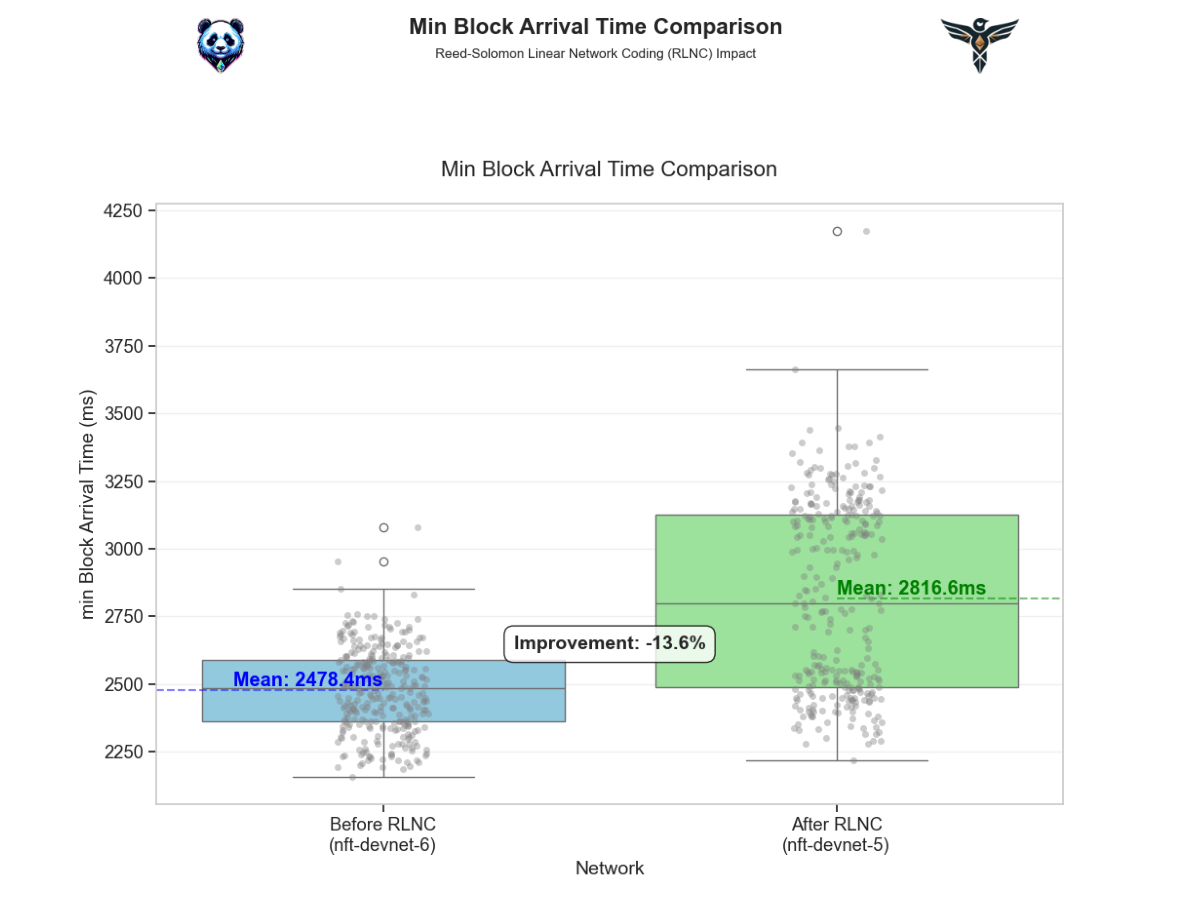

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/1007521073.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title


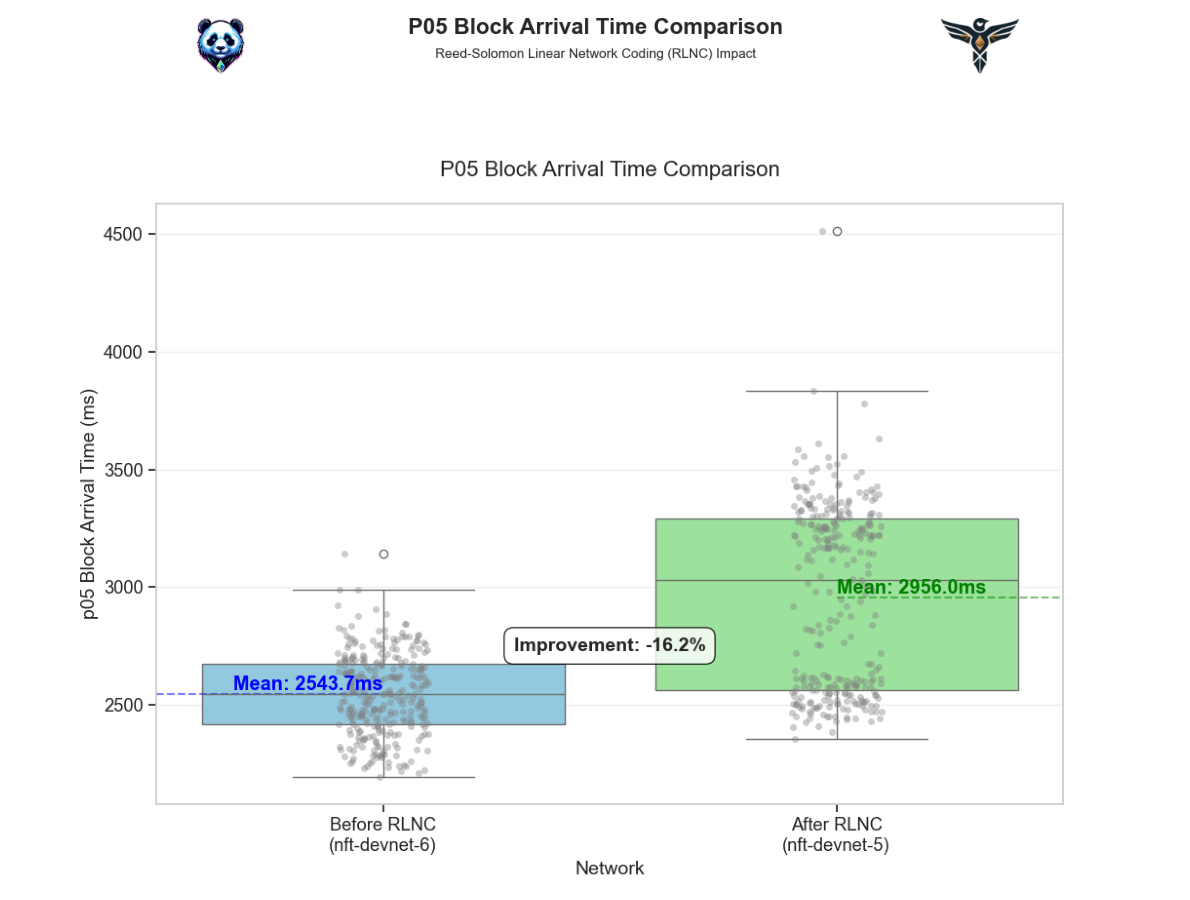

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/1007521073.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title


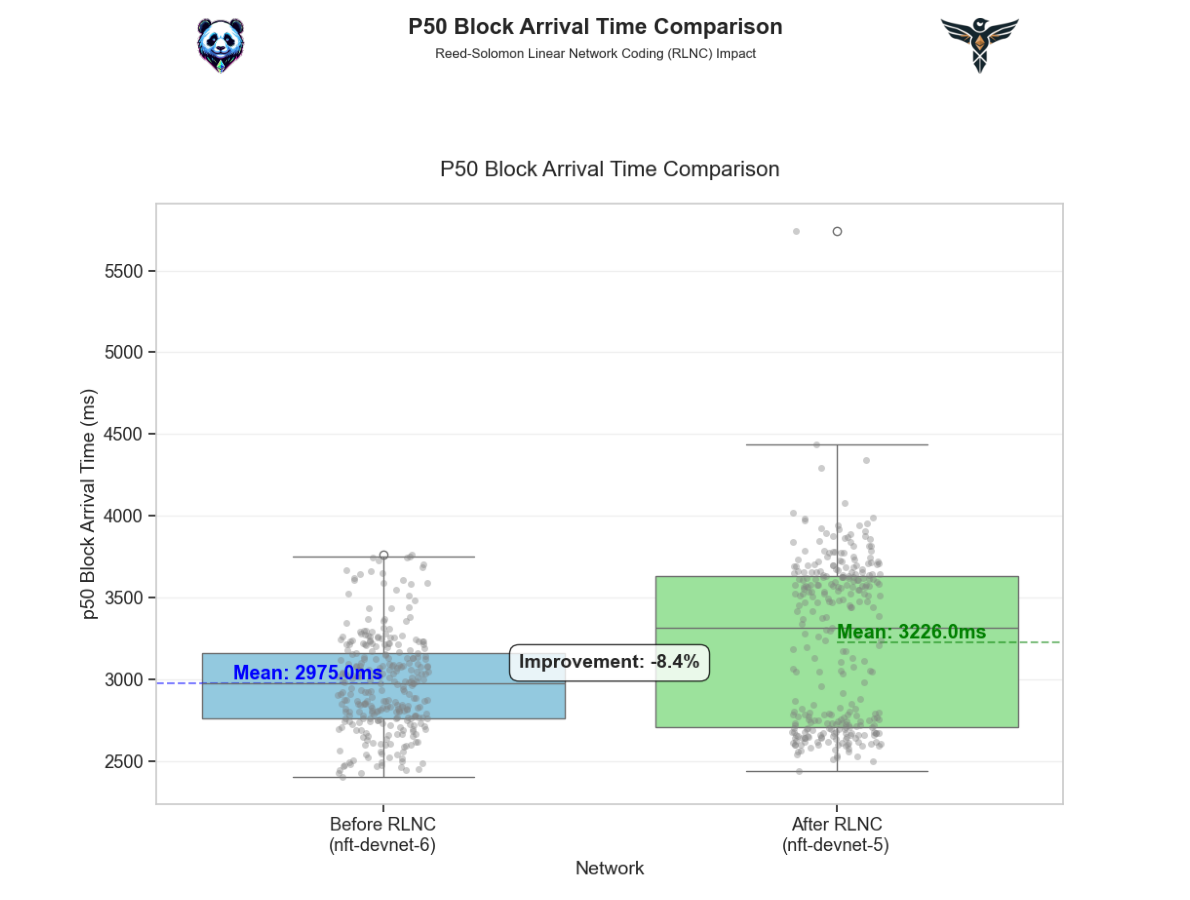

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/1007521073.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title


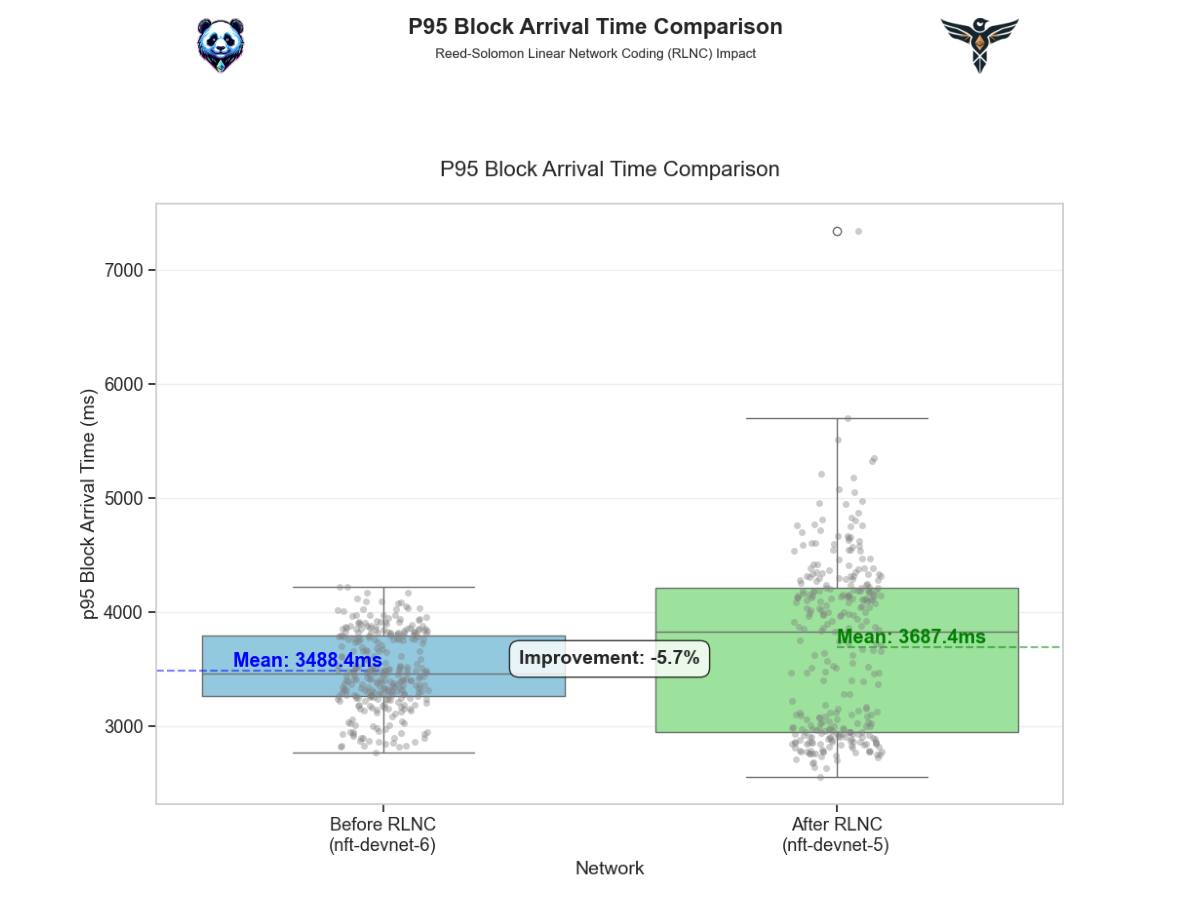

In [5]:
def create_boxplot(metrics_df, metric='p50_arrival_time', title=None, subtitle=None):
    """
    Create a box plot comparing before and after networks for a specified metric.
    
    Args:
        metrics_df (DataFrame): Combined metrics from both networks
        metric (str): The metric to plot
        title (str, optional): Title for the plot
        subtitle (str, optional): Subtitle for the plot
        
    Returns:
        matplotlib.figure.Figure: The figure with the plot
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set x-ticks before creating the boxplot
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'Before RLNC\n({config["before"]["network"]})', 
                        f'After RLNC\n({config["after"]["network"]})'])
    
    # Create box plot with hue parameter for color differentiation
    sns.boxplot(
        x='network', 
        y=metric,
        hue='network', 
        data=metrics_df,
        palette={'before_rlnc': 'skyblue', 'after_rlnc': 'lightgreen'},
        ax=ax,
        legend=False
    )
    
    # Add individual data points
    sns.stripplot(
        x='network', 
        y=metric, 
        data=metrics_df,
        color='gray',
        alpha=0.4,
        jitter=True,
        ax=ax
    )
    
    # Set axis labels and title
    ax.set_xlabel('Network', fontsize=14)
    ax.set_ylabel(f'{metric.replace("_arrival_time", "")} Block Arrival Time (ms)', fontsize=14)
    
    if title:
        ax.set_title(title, fontsize=16, pad=20)
    
    # Add grid for readability
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add average line only if data exists
    before_data = metrics_df[metrics_df['network'] == 'before_rlnc'][metric]
    after_data = metrics_df[metrics_df['network'] == 'after_rlnc'][metric]
    
    if not before_data.empty:
        before_avg = before_data.mean()
        ax.axhline(before_avg, color='blue', linestyle='--', alpha=0.5, xmin=0, xmax=0.25)
        ax.text(0, before_avg, f'Mean: {before_avg:.1f}ms', 
                ha='right', va='bottom', color='blue', fontweight='bold')
    
    if not after_data.empty:
        after_avg = after_data.mean()
        ax.axhline(after_avg, color='green', linestyle='--', alpha=0.5, xmin=0.75, xmax=1)
        ax.text(1, after_avg, f'Mean: {after_avg:.1f}ms', 
                ha='left', va='bottom', color='green', fontweight='bold')
    
    # Add improvement percentage only if both datasets exist and have valid means
    if not before_data.empty and not after_data.empty:
        before_avg = before_data.mean()
        after_avg = after_data.mean()
        
        if not np.isnan(before_avg) and not np.isnan(after_avg) and before_avg > 0:
            improvement_pct = (before_avg - after_avg) / before_avg * 100
            improvement_text = f'Improvement: {improvement_pct:.1f}%'
            mid_y = (before_avg + after_avg) / 2
            ax.text(0.5, mid_y, improvement_text,
                    ha='center', va='center', fontsize=14, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Add branding if title and subtitle are provided
    if title and subtitle:
        fig = add_branding(fig, title, subtitle)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title
    
    return fig

# Create box plots for different metrics
metrics_to_plot = ['min_arrival_time', 'p05_arrival_time', 'p50_arrival_time', 'p95_arrival_time']
for metric in metrics_to_plot:
    title = f"{metric.replace('_arrival_time', '').title()} Block Arrival Time Comparison"
    
    fig = create_boxplot(all_metrics, metric, title, subtitle)
    plt.show()

## Visualization: Time Series Analysis

Let's plot the arrival times over time to see any patterns.

In [6]:
def create_timeseries_plot(before_metrics, after_metrics, metric='p50_arrival_time', window=100):
    """
    Create a time series plot with rolling average for both networks.
    
    Args:
        before_metrics (DataFrame): Metrics for the before network
        after_metrics (DataFrame): Metrics for the after network
        metric (str): The metric to plot
        window (int): Window size for rolling average
        
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Sort by slot
    before_metrics = before_metrics.sort_values('slot')
    after_metrics = after_metrics.sort_values('slot')
    
    # Calculate rolling averages
    before_metrics['rolling_avg'] = before_metrics[metric].rolling(window=window, min_periods=1).mean()
    after_metrics['rolling_avg'] = after_metrics[metric].rolling(window=window, min_periods=1).mean()
    
    # Create figure
    fig = go.Figure()
    
    # Add scatter plots for raw data
    fig.add_trace(go.Scatter(
        x=before_metrics['slot'],
        y=before_metrics[metric],
        mode='markers',
        name=f'Before RLNC ({config["before"]["network"]})',
        marker=dict(color='royalblue', size=5, opacity=0.5),
        hovertemplate='Slot: %{x}<br>Arrival Time: %{y:.1f}ms'
    ))
    
    fig.add_trace(go.Scatter(
        x=after_metrics['slot'],
        y=after_metrics[metric],
        mode='markers',
        name=f'After RLNC ({config["after"]["network"]})',
        marker=dict(color='green', size=5, opacity=0.5),
        hovertemplate='Slot: %{x}<br>Arrival Time: %{y:.1f}ms'
    ))
    
    # Add rolling average lines
    fig.add_trace(go.Scatter(
        x=before_metrics['slot'],
        y=before_metrics['rolling_avg'],
        mode='lines',
        name=f'Before RLNC Rolling Avg ({window} slots)',
        line=dict(color='navy', width=3),
        hovertemplate='Slot: %{x}<br>Rolling Avg: %{y:.1f}ms'
    ))
    
    fig.add_trace(go.Scatter(
        x=after_metrics['slot'],
        y=after_metrics['rolling_avg'],
        mode='lines',
        name=f'After RLNC Rolling Avg ({window} slots)',
        line=dict(color='darkgreen', width=3),
        hovertemplate='Slot: %{x}<br>Rolling Avg: %{y:.1f}ms'
    ))
    
    # Add horizontal lines for overall averages
    before_avg = before_metrics[metric].mean()
    after_avg = after_metrics[metric].mean()
    
    fig.add_trace(go.Scatter(
        x=[before_metrics['slot'].min(), before_metrics['slot'].max()],
        y=[before_avg, before_avg],
        mode='lines',
        name=f'Before RLNC Average: {before_avg:.1f}ms',
        line=dict(color='navy', width=2, dash='dash'),
        hoverinfo='name'
    ))
    
    fig.add_trace(go.Scatter(
        x=[after_metrics['slot'].min(), after_metrics['slot'].max()],
        y=[after_avg, after_avg],
        mode='lines',
        name=f'After RLNC Average: {after_avg:.1f}ms',
        line=dict(color='darkgreen', width=2, dash='dash'),
        hoverinfo='name'
    ))
    
    # Update layout
    fig.update_layout(
        title={
            'text': f"{metric.replace('_arrival_time', '').title()} Block Arrival Time Over Time",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20)
        },
        xaxis_title="Slot Number",
        yaxis_title="Arrival Time (ms)",
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        hovermode='closest',
        plot_bgcolor='white',
        height=600,
        width=1000
    )
    
    # Add improvement annotation
    if before_avg > 0:
        improvement_pct = (before_avg - after_avg) / before_avg * 100
        fig.add_annotation(
            x=0.5,
            y=1.05,
            xref="paper",
            yref="paper",
            text=f"Overall Improvement: {improvement_pct:.1f}%",
            showarrow=False,
            font=dict(size=16, color="black"),
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="rgba(0,0,0,0.5)",
            borderwidth=1,
            borderpad=4
        )
    
    return fig

# Create time series plots for different metrics
for metric in metrics_to_plot:
    fig = create_timeseries_plot(before_metrics, after_metrics, metric)
    fig.show()

## Percentile Analysis

Let's analyze the impact on different percentiles of arrival times.

## Block Size Analysis

Let's analyze how block size affects arrival times and if the RLNC implementation has a differential impact based on block size.

In [7]:
def create_block_size_scatter_plot(before_metrics, after_metrics, metric='p95_arrival_time'):
    """
    Create a scatter plot of block size vs arrival time.
    
    Args:
        before_metrics (DataFrame): Metrics for the before network
        after_metrics (DataFrame): Metrics for the after network
        metric (str): The metric to plot (e.g., 'p95_arrival_time')
        
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Create figure
    fig = go.Figure()
    
    # Add scatter plot for before network
    fig.add_trace(go.Scatter(
        x=before_metrics['block_total_bytes'],
        y=before_metrics[metric],
        mode='markers',
        name=f'Before RLNC ({config["before"]["network"]})',
        marker=dict(
            color='royalblue',
            size=8,
            opacity=0.7,
            line=dict(width=1, color='darkblue')
        ),
        hovertemplate='Slot: %{text}<br>Block Size: %{x} bytes<br>%{yaxis.title.text}: %{y:.1f}ms',
        text=before_metrics['slot']
    ))
    
    # Add scatter plot for after network
    fig.add_trace(go.Scatter(
        x=after_metrics['block_total_bytes'],
        y=after_metrics[metric],
        mode='markers',
        name=f'After RLNC ({config["after"]["network"]})',
        marker=dict(
            color='green',
            size=8,
            opacity=0.7,
            line=dict(width=1, color='darkgreen')
        ),
        hovertemplate='Slot: %{text}<br>Block Size: %{x} bytes<br>%{yaxis.title.text}: %{y:.1f}ms',
        text=after_metrics['slot']
    ))
    
    # Add trend lines
    if not before_metrics.empty and 'block_total_bytes' in before_metrics.columns:
        before_metrics_filtered = before_metrics.dropna(subset=['block_total_bytes', metric])
        if not before_metrics_filtered.empty:
            try:
                x = before_metrics_filtered['block_total_bytes']
                y = before_metrics_filtered[metric]
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_range = np.linspace(x.min(), x.max(), 100)
                
                fig.add_trace(go.Scatter(
                    x=x_range,
                    y=p(x_range),
                    mode='lines',
                    name='Before RLNC Trend',
                    line=dict(color='royalblue', dash='dash', width=2),
                    hoverinfo='skip'
                ))
            except:
                # Skip trendline if there's an error (e.g., not enough data)
                pass
    
    if not after_metrics.empty and 'block_total_bytes' in after_metrics.columns:
        after_metrics_filtered = after_metrics.dropna(subset=['block_total_bytes', metric])
        if not after_metrics_filtered.empty:
            try:
                x = after_metrics_filtered['block_total_bytes']
                y = after_metrics_filtered[metric]
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_range = np.linspace(x.min(), x.max(), 100)
                
                fig.add_trace(go.Scatter(
                    x=x_range,
                    y=p(x_range),
                    mode='lines',
                    name='After RLNC Trend',
                    line=dict(color='green', dash='dash', width=2),
                    hoverinfo='skip'
                ))
            except:
                # Skip trendline if there's an error
                pass
    
    # Update layout
    fig.update_layout(
        title=f"Block Size vs {metric.replace('_arrival_time', '').title()} Arrival Time",
        xaxis_title="Block Size (bytes)",
        yaxis_title=f"{metric.replace('_arrival_time', '').title()} Arrival Time (ms)",
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        hovermode='closest',
        plot_bgcolor='white',
        height=600,
        width=1000,
        xaxis=dict(
            type='log',
            title_font=dict(size=14),
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title_font=dict(size=14),
            gridcolor='lightgray'
        )
    )
    
    return fig

def create_block_size_bin_analysis(before_metrics, after_metrics, metric='p95_arrival_time'):
    """
    Create a bar chart comparing arrival times binned by block size ranges.
    
    Args:
        before_metrics (DataFrame): Metrics for the before network
        after_metrics (DataFrame): Metrics for the after network
        metric (str): The metric to plot
        
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Drop NaN values
    before_metrics = before_metrics.dropna(subset=['block_total_bytes'])
    after_metrics = after_metrics.dropna(subset=['block_total_bytes'])
    
    # Define block size bins (in KB to make it easier to read)
    bins = [0, 50*1024, 100*1024, 150*1024, 200*1024, 500*1024, 1000*1024, float('inf')]
    bin_labels = ['0-50KB', '50-100KB', '100-150KB', '150-200KB', '200-500KB', '500KB-1MB', '>1MB']
    
    # Add block size bin column
    before_metrics['block_size_bin'] = pd.cut(before_metrics['block_total_bytes'], 
                                             bins=bins, labels=bin_labels)
    after_metrics['block_size_bin'] = pd.cut(after_metrics['block_total_bytes'], 
                                            bins=bins, labels=bin_labels)
    
    # Group by block size bin
    before_by_bin = before_metrics.groupby('block_size_bin').agg({
        metric: ['mean', 'std', 'count']
    }).reset_index()
    
    before_by_bin.columns = ['block_size_bin', 'mean', 'std', 'count']
    
    after_by_bin = after_metrics.groupby('block_size_bin').agg({
        metric: ['mean', 'std', 'count']
    }).reset_index()
    
    after_by_bin.columns = ['block_size_bin', 'mean', 'std', 'count']
    
    # Merge the dataframes
    merged = pd.merge(before_by_bin, after_by_bin, on='block_size_bin', how='outer', suffixes=('_before', '_after'))
    
    # Calculate improvement
    merged['improvement'] = merged['mean_before'] - merged['mean_after']
    merged['improvement_pct'] = (merged['mean_before'] - merged['mean_after']) / merged['mean_before'] * 100
    
    # Create figure with subplots
    fig = make_subplots(rows=2, cols=1, 
                       subplot_titles=(
                           f"{metric.replace('_arrival_time', '').title()} Arrival Time by Block Size",
                           "Improvement Percentage by Block Size"
                       ),
                       row_heights=[0.6, 0.4],
                       vertical_spacing=0.1)
    
    # Add bar chart for mean arrival times
    fig.add_trace(
        go.Bar(
            x=merged['block_size_bin'],
            y=merged['mean_before'],
            name=f'Before RLNC ({config["before"]["network"]})',
            error_y=dict(type='data', array=merged['std_before'], visible=True),
            marker_color='royalblue',
            text=merged['count_before'],
            hovertemplate='Block Size: %{x}<br>Arrival Time: %{y:.1f}ms<br>Sample Size: %{text}'
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Bar(
            x=merged['block_size_bin'],
            y=merged['mean_after'],
            name=f'After RLNC ({config["after"]["network"]})',
            error_y=dict(type='data', array=merged['std_after'], visible=True),
            marker_color='green',
            text=merged['count_after'],
            hovertemplate='Block Size: %{x}<br>Arrival Time: %{y:.1f}ms<br>Sample Size: %{text}'
        ),
        row=1, col=1
    )
    
    # Add improvement percentage as bar chart in second subplot
    fig.add_trace(
        go.Bar(
            x=merged['block_size_bin'],
            y=merged['improvement_pct'],
            name='Improvement %',
            marker_color=['green' if x > 0 else 'red' for x in merged['improvement_pct']],
            text=[f"{x:.1f}%" for x in merged['improvement_pct']],
            textposition='auto',
            hovertemplate='Block Size: %{x}<br>Improvement: %{y:.1f}%'
        ),
        row=2, col=1
    )
    
    # Add zero line to second subplot
    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=0,
        x1=len(bin_labels) - 0.5,
        y1=0,
        line=dict(color="black", width=1, dash="dash"),
        row=2, col=1
    )
    
    # Update layout
    fig.update_layout(
        title_text=f"Impact of RLNC on {metric.replace('_arrival_time', '').title()} Arrival Time by Block Size",
        xaxis=dict(title="Block Size", categoryorder='array', categoryarray=bin_labels),
        xaxis2=dict(title="Block Size", categoryorder='array', categoryarray=bin_labels),
        yaxis=dict(title="Arrival Time (ms)"),
        yaxis2=dict(title="Improvement (%)"),
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        barmode='group',
        height=800,
        width=1000,
        plot_bgcolor='white'
    )
    
    return fig

# Create scatter plots for block size vs arrival time
metrics_to_analyze = ['min_arrival_time', 'p50_arrival_time', 'p95_arrival_time']
for metric in metrics_to_analyze:
    fig = create_block_size_scatter_plot(before_metrics, after_metrics, metric)
    fig.show()
    
    # Create binned analysis
    fig = create_block_size_bin_analysis(before_metrics, after_metrics, metric)
    fig.show()

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:139: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:143: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:149: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:139: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:143: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:149: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:139: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:143: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/828859533.py:149: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

## Block Size Impact: Detailed Difference Analysis

Let's analyze how the RLNC implementation affects blocks of different sizes in more detail. We'll create charts that show the absolute and percentage differences in arrival times (After - Before) for different block size buckets, with all metrics (min, p05, p50, p95) displayed on the same chart for easy comparison.

In [19]:
def create_block_size_difference_chart(before_metrics, after_metrics):
    """
    Create a chart showing the difference in arrival times between before and after RLNC
    for different block size buckets, with multiple metrics on the same chart.
    
    Args:
        before_metrics (DataFrame): Metrics from before network
        after_metrics (DataFrame): Metrics from after network
        
    Returns:
        plotly.graph_objects.Figure: The figure with the chart
    """
    # Drop NaN values
    before_metrics = before_metrics.dropna(subset=['block_total_bytes'])
    after_metrics = after_metrics.dropna(subset=['block_total_bytes'])
    
    # Find the max block size in the data to set appropriate bins
    max_block_size = max(
        before_metrics['block_total_bytes'].max(),
        after_metrics['block_total_bytes'].max()
    )
    min_block_size = min(
        before_metrics['block_total_bytes'].min(),
        after_metrics['block_total_bytes'].min()
    )
    
    # Calculate optimal number of bins using Freedman-Diaconis rule
    # Combine data for bin calculation
    combined_sizes = pd.concat([
        before_metrics['block_total_bytes'],
        after_metrics['block_total_bytes']
    ])
    
    # Calculate IQR (Interquartile Range)
    q75, q25 = np.percentile(combined_sizes, [75, 25])
    iqr = q75 - q25
    
    # Calculate bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr * (len(combined_sizes) ** (-1/3))
    
    # Ensure bin width is at least 256KB to avoid too many bins
    bin_width = max(bin_width, 256 * 1024)
    
    # Round bin width to nearest 256KB for cleaner labels
    bin_width = np.ceil(bin_width / (256 * 1024)) * (256 * 1024)
    
    # Calculate number of bins
    num_bins = min(10, int(np.ceil((max_block_size - min_block_size) / bin_width)))
    
    # Create bins with more even distribution
    size_bins = np.linspace(0, max_block_size * 1.05, num_bins + 1).tolist()
    size_bins[-1] = float('inf')  # Set the last bin to infinity
    
    # Create labels for the bins
    size_labels = []
    for i in range(len(size_bins) - 1):
        if size_bins[i+1] == float('inf'):
            size_labels.append(f'>{size_bins[i]/1024/1024:.1f}MB')
        else:
            # Use MB for larger sizes for better readability
            if size_bins[i] >= 1024 * 1024:
                size_labels.append(f'{size_bins[i]/1024/1024:.1f}-{size_bins[i+1]/1024/1024:.1f}MB')
            else:
                size_labels.append(f'{size_bins[i]/1024:.0f}-{size_bins[i+1]/1024:.0f}KB')
    # Add block size bin column
    before_metrics['block_size_bin'] = pd.cut(before_metrics['block_total_bytes'], 
                                             bins=size_bins, labels=size_labels)
    after_metrics['block_size_bin'] = pd.cut(after_metrics['block_total_bytes'], 
                                            bins=size_bins, labels=size_labels)
    
    # Metrics to compare
    metrics = ['min_arrival_time', 'p05_arrival_time', 'p50_arrival_time', 'p95_arrival_time']
    metric_labels = ['min', 'p05', 'p50', 'p95']
    
    # Calculate average metrics by block size bin
    before_stats = before_metrics.groupby('block_size_bin')[metrics].mean().reset_index()
    after_stats = after_metrics.groupby('block_size_bin')[metrics].mean().reset_index()
    
    # Merge the stats
    merged_stats = pd.merge(before_stats, after_stats, on='block_size_bin', suffixes=('_before', '_after'))
    
    # Calculate absolute differences and percentage differences
    for metric in metrics:
        merged_stats[f'{metric}_diff'] = merged_stats[f'{metric}_after'] - merged_stats[f'{metric}_before']
        merged_stats[f'{metric}_diff_pct'] = ((merged_stats[f'{metric}_after'] - merged_stats[f'{metric}_before']) / 
                                            merged_stats[f'{metric}_before'] * 100)
    
    # Count samples in each bin
    before_counts = before_metrics.groupby('block_size_bin').size().reset_index(name='count_before')
    after_counts = after_metrics.groupby('block_size_bin').size().reset_index(name='count_after')
    merged_stats = pd.merge(merged_stats, before_counts, on='block_size_bin')
    merged_stats = pd.merge(merged_stats, after_counts, on='block_size_bin')
    
    # Create a figure for absolute differences
    fig1 = go.Figure()
    
    # Add lines for each metric
    colors = ['blue', 'green', 'orange', 'red']
    for i, metric in enumerate(metrics):
        fig1.add_trace(go.Scatter(
            x=merged_stats['block_size_bin'],
            y=merged_stats[f'{metric}_diff'],
            mode='lines+markers',
            name=f'{metric_labels[i]} Difference',
            line=dict(color=colors[i], width=2),
            marker=dict(size=8),
            hovertemplate='Block Size: %{x}<br>' + 
                         metric_labels[i] + ' Difference: %{y:.1f}ms<br>' +
                         'Before Samples: %{customdata[0]}<br>' +
                         'After Samples: %{customdata[1]}',
            customdata=merged_stats[['count_before', 'count_after']]
        ))
    
    # Add a horizontal line at y=0
    fig1.add_shape(
        type="line",
        x0=-0.5,
        y0=0,
        x1=len(size_labels) - 0.5,
        y1=0,
        line=dict(color="black", width=1, dash="dash")
    )
    
    # Add shaded regions to indicate improvement/degradation
    fig1.add_shape(
        type="rect",
        x0=-0.5,
        y0=0,
        x1=len(size_labels) - 0.5,
        y1=-1000,  # Large negative value to cover the bottom part
        fillcolor="rgba(0, 255, 0, 0.1)",  # Light green for improvement
        line=dict(width=0),
        layer="below"
    )
    
    fig1.add_shape(
        type="rect",
        x0=-0.5,
        y0=0,
        x1=len(size_labels) - 0.5,
        y1=1000,  # Large positive value to cover the top part
        fillcolor="rgba(255, 0, 0, 0.1)",  # Light red for degradation
        line=dict(width=0),
        layer="below"
    )
    
    # Add annotation to explain the colors - moved to top and bottom of their respective areas
    fig1.add_annotation(
        x=1,
        y=-950,  # Near the bottom of the green area
        text="Improvement (Lower Arrival Time)",
        showarrow=False,
        font=dict(size=12, color="green"),
        xanchor="left"
    )
    
    fig1.add_annotation(
        x=1,
        y=950,  # Near the top of the red area
        text="Degradation (Higher Arrival Time)",
        showarrow=False,
        font=dict(size=12, color="red"),
        xanchor="left"
    )
    
    # Update layout
    fig1.update_layout(
        title="Absolute Difference in Arrival Times by Block Size (After - Before)",
        xaxis=dict(
            title="Block Size",
            tickangle=45,
            tickmode='array',
            tickvals=list(range(len(size_labels))),
            ticktext=size_labels
        ),
        yaxis=dict(title="Difference (ms)"),
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        hovermode='closest',
        plot_bgcolor='white',
        height=600,
        width=1000
    )
    
    # Create a figure for percentage differences
    fig2 = go.Figure()
    
    # Add lines for each metric
    for i, metric in enumerate(metrics):
        fig2.add_trace(go.Scatter(
            x=merged_stats['block_size_bin'],
            y=merged_stats[f'{metric}_diff_pct'],
            mode='lines+markers',
            name=f'{metric_labels[i]} % Difference',
            line=dict(color=colors[i], width=2),
            marker=dict(size=8),
            hovertemplate='Block Size: %{x}<br>' + 
                         metric_labels[i] + ' % Difference: %{y:.1f}%<br>' +
                         'Before Samples: %{customdata[0]}<br>' +
                         'After Samples: %{customdata[1]}',
            customdata=merged_stats[['count_before', 'count_after']]
        ))
    
    # Add a horizontal line at y=0
    fig2.add_shape(
        type="line",
        x0=-0.5,
        y0=0,
        x1=len(size_labels) - 0.5,
        y1=0,
        line=dict(color="black", width=1, dash="dash")
    )
    
    # Add shaded regions to indicate improvement/degradation
    fig2.add_shape(
        type="rect",
        x0=-0.5,
        y0=0,
        x1=len(size_labels) - 0.5,
        y1=-100,  # Large negative value to cover the bottom part
        fillcolor="rgba(0, 255, 0, 0.1)",  # Light green for improvement
        line=dict(width=0),
        layer="below"
    )
    
    fig2.add_shape(
        type="rect",
        x0=-0.5,
        y0=0,
        x1=len(size_labels) - 0.5,
        y1=100,  # Large positive value to cover the top part
        fillcolor="rgba(255, 0, 0, 0.1)",  # Light red for degradation
        line=dict(width=0),
        layer="below"
    )
    
    # Add annotation to explain the colors - moved to top and bottom of their respective areas
    fig2.add_annotation(
        x=0,
        y=-95,  # Near the bottom of the green area
        text="Improvement (Lower Arrival Time)",
        showarrow=False,
        font=dict(size=12, color="green"),
        xanchor="left"
    )
    
    fig2.add_annotation(
        x=0,
        y=95,  # Near the top of the red area
        text="Degradation (Higher Arrival Time)",
        showarrow=False,
        font=dict(size=12, color="red"),
        xanchor="left"
    )
    
    # Update layout
    fig2.update_layout(
        title="Percentage Difference in Arrival Times by Block Size ((After - Before)/Before × 100%)",
        xaxis=dict(
            title="Block Size",
            tickangle=45,
            tickmode='array',
            tickvals=list(range(len(size_labels))),
            ticktext=size_labels
        ),
        yaxis=dict(title="% Difference"),
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        hovermode='closest',
        plot_bgcolor='white',
        height=600,
        width=1000
    )
    
    # Show the figures
    fig1.show()
    fig2.show()
    
    # Create a table showing the actual values with color coding for improvement/degradation
    table_data = [
        ['Block Size', 'Sample Count (Before/After)'] + 
        [f'{label} Before' for label in metric_labels] + 
        [f'{label} After' for label in metric_labels] +
        [f'{label} Diff (ms)' for label in metric_labels] + 
        [f'{label} Diff (%)' for label in metric_labels]
    ]
    
    # Prepare cell colors for the table
    cell_colors = [['white'] * len(merged_stats) for _ in range(len(table_data[0]))]
    
    # Start with default colors
    for i in range(len(merged_stats)):
        for j in range(2, len(table_data[0])):  # Skip the first two columns
            cell_colors[j][i] = 'white'
    
    # Set colors for difference columns
    diff_start_idx = 2 + len(metrics) * 2  # Index where diff columns start
    for i, _ in enumerate(merged_stats.iterrows()):
        for j, metric in enumerate(metrics):
            # Color for absolute difference
            diff_col_idx = diff_start_idx + j
            if merged_stats.iloc[i][f'{metric}_diff'] < 0:
                cell_colors[diff_col_idx][i] = 'rgba(0, 255, 0, 0.2)'  # Light green for improvement
            else:
                cell_colors[diff_col_idx][i] = 'rgba(255, 0, 0, 0.2)'  # Light red for degradation
            
            # Color for percentage difference
            pct_col_idx = diff_start_idx + len(metrics) + j
            if merged_stats.iloc[i][f'{metric}_diff_pct'] < 0:
                cell_colors[pct_col_idx][i] = 'rgba(0, 255, 0, 0.2)'  # Light green for improvement
            else:
                cell_colors[pct_col_idx][i] = 'rgba(255, 0, 0, 0.2)'  # Light red for degradation
    
    for _, row in merged_stats.iterrows():
        table_row = [
            row['block_size_bin'],
            f"{int(row['count_before'])}/{int(row['count_after'])}"
        ]
        
        # Add before values
        for metric in metrics:
            table_row.append(f"{row[f'{metric}_before']:.1f}")
        
        # Add after values
        for metric in metrics:
            table_row.append(f"{row[f'{metric}_after']:.1f}")
        
        # Add difference values
        for metric in metrics:
            diff_value = row[f'{metric}_diff']
            # Add a "+" sign for positive values to make it more obvious
            sign = "+" if diff_value > 0 else ""
            table_row.append(f"{sign}{diff_value:.1f}")
        
        # Add percentage differences
        for metric in metrics:
            diff_pct = row[f'{metric}_diff_pct']
            # Add a "+" sign for positive values to make it more obvious
            sign = "+" if diff_pct > 0 else ""
            table_row.append(f"{sign}{diff_pct:.1f}%")
        
        table_data.append(table_row)
    
    # Create table figure with color-coded cells
    table_fig = go.Figure(data=[go.Table(
        header=dict(
            values=table_data[0],
            fill_color='paleturquoise',
            align='center',
            font=dict(size=12)
        ),
        cells=dict(
            values=[[row[i] for row in table_data[1:]] for i in range(len(table_data[0]))],
            fill_color=cell_colors,
            align='center',
            font=dict(size=11)
        )
    )])
    
    # Add a legend for the table
    table_fig.update_layout(
        title="Detailed Metrics by Block Size<br><span style='font-size:12px'>Green = Improvement (Lower Arrival Time), Red = Degradation (Higher Arrival Time)</span>",
        height=400,
        width=1200
    )
    
    table_fig.show()
    
    return [fig1, fig2, table_fig]

# Create the block size difference chart
diff_charts = create_block_size_difference_chart(before_metrics, after_metrics)

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/2614098189.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/2614098189.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/2614098189.py:77: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

In [8]:
def create_block_size_analysis(before_metrics, after_metrics):
    """
    Create a comprehensive analysis of block size impact on arrival times.
    
    Args:
        before_metrics (DataFrame): Metrics for the before network
        after_metrics (DataFrame): Metrics for the after network
        
    Returns:
        plotly.graph_objects.Figure: The figure with block size analysis
    """
    # Drop NaN values
    before_metrics = before_metrics.dropna(subset=['block_total_bytes', 'p95_arrival_time'])
    after_metrics = after_metrics.dropna(subset=['block_total_bytes', 'p95_arrival_time'])
    
    # Define block size bins (in KB to make it easier to read)
    size_bins = [0, 50*1024, 100*1024, 200*1024, 500*1024, 1000*1024, float('inf')]
    size_labels = ['0-50KB', '50-100KB', '100-200KB', '200-500KB', '500KB-1MB', '>1MB']
    
    # Add block size bin column
    before_metrics['block_size_bin'] = pd.cut(before_metrics['block_total_bytes'], 
                                             bins=size_bins, labels=size_labels)
    after_metrics['block_size_bin'] = pd.cut(after_metrics['block_total_bytes'], 
                                            bins=size_bins, labels=size_labels)
    
    # Calculate statistics by block size bin
    before_stats = before_metrics.groupby('block_size_bin').agg({
        'p95_arrival_time': ['mean', 'std', 'count'],
        'p50_arrival_time': 'mean',
        'min_arrival_time': 'mean'
    }).reset_index()
    
    # Flatten the MultiIndex columns
    before_stats.columns = ['block_size_bin', 'p95_mean', 'p95_std', 'count', 'p50_mean', 'min_mean']
    
    after_stats = after_metrics.groupby('block_size_bin').agg({
        'p95_arrival_time': ['mean', 'std', 'count'],
        'p50_arrival_time': 'mean',
        'min_arrival_time': 'mean'
    }).reset_index()
    
    # Flatten the MultiIndex columns
    after_stats.columns = ['block_size_bin', 'p95_mean', 'p95_std', 'count', 'p50_mean', 'min_mean']
    
    # Merge stats
    combined_stats = pd.merge(
        before_stats, 
        after_stats, 
        on='block_size_bin', 
        suffixes=('_before', '_after')
    )
    
    # Calculate improvement
    combined_stats['p95_improvement'] = ((combined_stats['p95_mean_before'] - combined_stats['p95_mean_after']) / 
                                       combined_stats['p95_mean_before'] * 100)
    combined_stats['p50_improvement'] = ((combined_stats['p50_mean_before'] - combined_stats['p50_mean_after']) / 
                                       combined_stats['p50_mean_before'] * 100)
    combined_stats['min_improvement'] = ((combined_stats['min_mean_before'] - combined_stats['min_mean_after']) / 
                                      combined_stats['min_mean_before'] * 100)
    
    # Create a figure with subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            "P95 Arrival Time by Block Size",
            "P50 Arrival Time by Block Size",
            "Arrival Time Improvement by Block Size"
        ),
        specs=[
            [{"type": "bar"}, {"type": "bar"}],
            [{"type": "bar", "colspan": 2}, None]
        ],
        row_heights=[0.6, 0.4],
        column_widths=[0.5, 0.5],
        vertical_spacing=0.12,
        horizontal_spacing=0.08
    )
    
    # Add traces for P95 arrival time
    fig.add_trace(
        go.Bar(
            x=combined_stats['block_size_bin'],
            y=combined_stats['p95_mean_before'],
            error_y=dict(type='data', array=combined_stats['p95_std_before'], visible=True),
            name=f'Before RLNC ({config["before"]["network"]})',
            marker_color='royalblue',
            text=combined_stats['count_before'],
            textposition='auto',
            hovertemplate='Block Size: %{x}<br>P95 Arrival: %{y:.1f}ms<br>Sample Size: %{text}'
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Bar(
            x=combined_stats['block_size_bin'],
            y=combined_stats['p95_mean_after'],
            error_y=dict(type='data', array=combined_stats['p95_std_after'], visible=True),
            name=f'After RLNC ({config["after"]["network"]})',
            marker_color='green',
            text=combined_stats['count_after'],
            textposition='auto',
            hovertemplate='Block Size: %{x}<br>P95 Arrival: %{y:.1f}ms<br>Sample Size: %{text}'
        ),
        row=1, col=1
    )
    
    # Add traces for P50 arrival time
    fig.add_trace(
        go.Bar(
            x=combined_stats['block_size_bin'],
            y=combined_stats['p50_mean_before'],
            name=f'Before RLNC ({config["before"]["network"]})',
            marker_color='royalblue',
            showlegend=False,
            hovertemplate='Block Size: %{x}<br>P50 Arrival: %{y:.1f}ms'
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Bar(
            x=combined_stats['block_size_bin'],
            y=combined_stats['p50_mean_after'],
            name=f'After RLNC ({config["after"]["network"]})',
            marker_color='green',
            showlegend=False,
            hovertemplate='Block Size: %{x}<br>P50 Arrival: %{y:.1f}ms'
        ),
        row=1, col=2
    )
    
    # Add traces for improvement
    fig.add_trace(
        go.Bar(
            x=combined_stats['block_size_bin'],
            y=combined_stats['p95_improvement'],
            name='P95 Improvement',
            marker_color=['green' if x > 0 else 'red' for x in combined_stats['p95_improvement']],
            text=[f"{x:.1f}%" for x in combined_stats['p95_improvement']],
            textposition='auto',
            hovertemplate='Block Size: %{x}<br>P95 Improvement: %{y:.1f}%'
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Bar(
            x=combined_stats['block_size_bin'],
            y=combined_stats['p50_improvement'],
            name='P50 Improvement',
            marker_color=['green' if x > 0 else 'red' for x in combined_stats['p50_improvement']],
            text=[f"{x:.1f}%" for x in combined_stats['p50_improvement']],
            textposition='auto',
            hovertemplate='Block Size: %{x}<br>P50 Improvement: %{y:.1f}%'
        ),
        row=2, col=1
    )
    
    # Add zero line to improvement plot
    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=0,
        x1=len(size_labels) - 0.5,
        y1=0,
        line=dict(color="black", width=1, dash="dash"),
        row=2, col=1
    )
    
    # Update layout
    fig.update_layout(
        title_text="Effect of Block Size on RLNC Performance",
        barmode='group',
        height=800,
        width=1000,
        plot_bgcolor='white',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        xaxis=dict(title="Block Size", categoryorder='array', categoryarray=size_labels),
        xaxis2=dict(title="Block Size", categoryorder='array', categoryarray=size_labels),
        xaxis3=dict(title="Block Size", categoryorder='array', categoryarray=size_labels),
        yaxis=dict(title="P95 Arrival Time (ms)"),
        yaxis2=dict(title="P50 Arrival Time (ms)"),
        yaxis3=dict(title="Improvement (%)")
    )
    
    return fig

# Create block size impact analysis
fig = create_block_size_analysis(before_metrics, after_metrics)
fig.show()

# Create scatter plot with both arrival time and block size over time
def create_temporal_analysis_plot():
    """
    Create a plot showing arrival times and block sizes over time.
    
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add traces for p95 arrival time
    fig.add_trace(
        go.Scatter(
            x=before_metrics['slot'],
            y=before_metrics['p95_arrival_time'],
            mode='markers',
            name=f'Before RLNC P95 Time ({config["before"]["network"]})',
            marker=dict(color='royalblue', size=8, opacity=0.7),
            hovertemplate='Slot: %{x}<br>p95 Arrival Time: %{y:.1f}ms'
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=after_metrics['slot'],
            y=after_metrics['p95_arrival_time'],
            mode='markers',
            name=f'After RLNC P95 Time ({config["after"]["network"]})',
            marker=dict(color='green', size=8, opacity=0.7),
            hovertemplate='Slot: %{x}<br>p95 Arrival Time: %{y:.1f}ms'
        ),
        secondary_y=False
    )
    
    # Add traces for block size
    fig.add_trace(
        go.Scatter(
            x=before_metrics['slot'],
            y=before_metrics['block_total_bytes'],
            mode='markers',
            name=f'Before RLNC Block Size ({config["before"]["network"]})',
            marker=dict(color='darkblue', size=8, opacity=0.5, symbol='x'),
            hovertemplate='Slot: %{x}<br>Block Size: %{y} bytes'
        ),
        secondary_y=True
    )
    
    fig.add_trace(
        go.Scatter(
            x=after_metrics['slot'],
            y=after_metrics['block_total_bytes'],
            mode='markers',
            name=f'After RLNC Block Size ({config["after"]["network"]})',
            marker=dict(color='darkgreen', size=8, opacity=0.5, symbol='x'),
            hovertemplate='Slot: %{x}<br>Block Size: %{y} bytes'
        ),
        secondary_y=True
    )
    
    # Add trend lines for p95 arrival time
    if not before_metrics.empty:
        before_metrics_filtered = before_metrics.dropna(subset=['slot', 'p95_arrival_time'])
        if not before_metrics_filtered.empty:
            try:
                x = before_metrics_filtered['slot']
                y = before_metrics_filtered['p95_arrival_time']
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_range = np.linspace(x.min(), x.max(), 100)
                
                fig.add_trace(
                    go.Scatter(
                        x=x_range,
                        y=p(x_range),
                        mode='lines',
                        name='Before RLNC P95 Trend',
                        line=dict(color='royalblue', dash='dash', width=2),
                        hoverinfo='skip'
                    ),
                    secondary_y=False
                )
            except:
                pass
    
    if not after_metrics.empty:
        after_metrics_filtered = after_metrics.dropna(subset=['slot', 'p95_arrival_time'])
        if not after_metrics_filtered.empty:
            try:
                x = after_metrics_filtered['slot']
                y = after_metrics_filtered['p95_arrival_time']
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_range = np.linspace(x.min(), x.max(), 100)
                
                fig.add_trace(
                    go.Scatter(
                        x=x_range,
                        y=p(x_range),
                        mode='lines',
                        name='After RLNC P95 Trend',
                        line=dict(color='green', dash='dash', width=2),
                        hoverinfo='skip'
                    ),
                    secondary_y=False
                )
            except:
                pass
    
    # Update axis labels
    fig.update_xaxes(title_text="Slot")
    fig.update_yaxes(title_text="p95 Arrival Time (ms)", secondary_y=False)
    fig.update_yaxes(title_text="Block Size (bytes)", secondary_y=True, type='log')
    
    # Update layout
    fig.update_layout(
        title="Block Size and p95 Arrival Time Over Time",
        hovermode="closest",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
        height=600,
        width=1000,
        plot_bgcolor='white'
    )
    
    return fig

# Create temporal analysis plot
fig = create_temporal_analysis_plot()
fig.show()

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/1970942819.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/1970942819.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_23734/1970942819.py:36: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 